In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import itertools
import numpy as np
import gpflow
import gpflow as gpf
import tensorflow as tf
from gpflow.ci_utils import ci_niter
import time
from sklearn.metrics import r2_score
from typing import Dict, Optional, Tuple

np.random.seed(0)
rng = np.random.RandomState(123)
%matplotlib inline
plt.style.use("ggplot")

In [2]:
import h5py
m1=h5py.File('D:\\MRLVGP_MATLAB\\SV_LVGP\\CaseStudy\\CaseStudy2\\XN.mat','r')
X=m1['X'][:]
X=X.transpose()
X[:,2:]=X[:,2:]-1

m2=h5py.File('D:\\MRLVGP_MATLAB\\SV_LVGP\\CaseStudy\\CaseStudy2\\YN_New.mat','r')
Y=m2['Y'][:]
Y=Y.transpose()


In [3]:
ma=h5py.File('D:\\MRLVGP_MATLAB\\SV_LVGP\\CaseStudy\\CaseStudy2\\Ymin.mat','r')
Ymin=ma['Y_min'][:]
Ymin=Ymin.transpose()


mb=h5py.File('D:\\MRLVGP_MATLAB\\SV_LVGP\\CaseStudy\\CaseStudy2\\Yrange_New.mat','r')
Yrange=mb['Yrange'][:]
Yrange=Yrange.transpose()


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1,test_size=0.1)

In [5]:
Yrange.shape

(1, 2)

In [6]:
N = X_train.shape[0]  # number of points
D = 4  # number of input dimensions
M = 100  # number of inducing points
L = 2  # number of latent GPs
P = 2  # number of observations = output dimensions

In [7]:
class KernelWithEmbedding(gpf.kernels.Kernel):
    def __init__(
        self,
        input_shape: Tuple,
        input_dim: Tuple,
        output_dim: int,
        kernels: gpf.kernels.Kernel,
        batch_size: Optional[int] = None,
    ):
        super().__init__()
        with self.name_scope:
            self.kernels = kernels
            self.input_shape = input_shape
            self.input_dim = input_dim
            self.output_dim = output_dim
#             self.embedding_matrix=embedding_matrix

            data_input = tf.keras.layers.Input(shape=input_shape,name='input')
            x = tf.keras.layers.Reshape((input_shape[0],1),input_shape=input_shape)(data_input)
            x1= tf.keras.layers.Cropping1D(cropping=(0,2))(x)
            x2= tf.keras.layers.Cropping1D(cropping=(2,1))(x)
            x3= tf.keras.layers.Cropping1D(cropping=(3,0))(x)
            x2= tf.keras.layers.Embedding(self.input_dim[0], self.output_dim)(x2)
            x3= tf.keras.layers.Embedding(self.input_dim[1], self.output_dim)(x3)

            x1=tf.keras.layers.Reshape((2,))(x1)
            x2=tf.keras.layers.Reshape((2,))(x2)
            x3=tf.keras.layers.Reshape((2,))(x3)

            output=tf.keras.layers.concatenate([x1,x2,x3],axis=1,dtype='float64')

            self.emb= tf.keras.models.Model(data_input , output)

    def K(self, a_input: tf.Tensor, b_input: Optional[tf.Tensor] = None) -> tf.Tensor:
        transformed_a = tf.squeeze(self.emb(a_input))
        transformed_b = tf.squeeze(self.emb(b_input)) if b_input is not None else b_input
        return self.kernels.K(transformed_a, transformed_b)

    def K_diag(self, a_input: tf.Tensor) -> tf.Tensor:
        transformed_a = tf.squeeze(self.emb(a_input))
        return self.kernels.K_diag(transformed_a)

In [8]:
from gpflow.inducing_variables import (
    FallbackSharedIndependentInducingVariables,
    SharedIndependentInducingVariables,
)
from typing import Union
from gpflow.kernels import (
    IndependentLatent,
    LinearCoregionalization,
    MultioutputKernel,
    SeparateIndependent,
    SharedIndependent,
)

@gpf.covariances.Kuu.register(SharedIndependentInducingVariables, KernelWithEmbedding)
def Kuu(inducing_variable:SharedIndependentInducingVariables, kernel:KernelWithEmbedding, jitter=None):
    return gpf.covariances.Kuu(inducing_variable, kernel.kernels,jitter=jitter)


@gpf.covariances.Kuf.register(SharedIndependentInducingVariables, KernelWithEmbedding, object)
def Kuf(inducing_variable:SharedIndependentInducingVariables, kernel:KernelWithEmbedding, Xnew):
    return gpf.covariances.Kuf(inducing_variable, kernel.kernels, kernel.emb(Xnew))

@gpf.conditionals.conditional.register(
    object,
    SharedIndependentInducingVariables,
    KernelWithEmbedding,
    object,
)
def coregionalization_conditional(
    Xnew,
    inducing_variable,
    kernel,
    f,
    *,
    full_cov=False,
    full_output_cov=False,
    q_sqrt=None,
    white=False,
):
    return gpf.conditionals.conditional(kernel.emb(Xnew),inducing_variable, kernel.kernels, f,q_sqrt=q_sqrt,full_cov=full_cov,white=white,full_output_cov=full_output_cov,)


In [10]:
import random
dim_z=2
ind_qual=[2,3]
n_lvs_qual=[5,5]
p_qual=2
kern_list = [gpf.kernels.SquaredExponential(active_dims=[0])*gpf.kernels.SquaredExponential(active_dims=[1])*gpf.kernels.SquaredExponential(active_dims=range(2,4))*gpf.kernels.SquaredExponential(active_dims=range(4,6)) for _ in range(L)] 
kernel_t = gpf.kernels.LinearCoregionalization(
    kern_list, W=np.random.randn(P, L)
)   # Notice that we initialise the mixing matrix W
kernel=KernelWithEmbedding((4,),n_lvs_qual,2,kernel_t) 
arr = np.arange(N)
np.random.shuffle(arr)
Z_o = X_train[arr[:M], :].copy()  # Initialize inducing locations to the first M inputs in the dataset
Zinit=kernel.emb(Z_o).numpy()
Z = Zinit.copy()
iv = gpf.inducing_variables.SharedIndependentInducingVariables(gpf.inducing_variables.InducingPoints(Z))
# initialize mean of variational posterior to be of shape MxL
q_mu = np.zeros((M, L))
# initialize \sqrt(Σ) of variational posterior to be of shape LxMxM
q_sqrt = np.repeat(np.eye(M)[None, ...], L, axis=0) * 1.0

In [11]:
m = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), iv,num_data=N, q_mu=q_mu, q_sqrt=q_sqrt)

In [12]:
m

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels.kernels[0].kernels[0].variance,Parameter,Softplus,,True,(),float64,0.9999999999999999
SVGP.kernel.kernels.kernels[0].kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.9999999999999999
SVGP.kernel.kernels.kernels[0].kernels[1].variance,Parameter,Softplus,,True,(),float64,0.9999999999999999
SVGP.kernel.kernels.kernels[0].kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.9999999999999999
SVGP.kernel.kernels.kernels[0].kernels[2].variance,Parameter,Softplus,,True,(),float64,0.9999999999999999
SVGP.kernel.kernels.kernels[0].kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,0.9999999999999999
SVGP.kernel.kernels.kernels[0].kernels[3].variance,Parameter,Softplus,,True,(),float64,0.9999999999999999
SVGP.kernel.kernels.kernels[0].kernels[3].lengthscales,Parameter,Softplus,,True,(),float64,0.9999999999999999
SVGP.kernel.kernels.kernels[1].kernels[0].variance,Parameter,Softplus,,True,(),float64,0.9999999999999999
SVGP.kernel.kernels.kernels[1].kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.9999999999999999


In [13]:
minibatch_size = 100

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).repeat().shuffle(N)

train_iter = iter(train_dataset.batch(minibatch_size))

In [14]:
import gpflow 
minibatch_size = 100

# We turn off training for inducing point locations
gpflow.set_trainable(m.inducing_variable, True)
# gpflow.set_trainable(m.z_vec, True)
for i in range(0,L):
    gpflow.set_trainable(m.kernel.kernels.kernels[i].kernels[1].variance,False)
    gpflow.set_trainable(m.kernel.kernels.kernels[i].kernels[2].variance,False)
    gpflow.set_trainable(m.kernel.kernels.kernels[i].kernels[3].variance,False)
    
gpflow.set_trainable(m.q_mu, False)
gpflow.set_trainable(m.q_sqrt, False)


def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)
    natgrad_adam_opt = tf.optimizers.Adam()
    natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
    variational_params = [(model.q_mu, model.q_sqrt)]

    @tf.function
    def optimization_step():
        natgrad_adam_opt.minimize(training_loss, model.trainable_variables)
        natgrad_opt.minimize(training_loss, var_list=variational_params)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf

Instructions for updating:
Use fn_output_signature instead


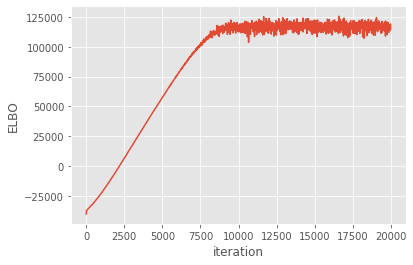

In [15]:
import time
maxiter = ci_niter(20000)

time_start=time.time()
logf = run_adam(m, maxiter)
time_end=time.time()
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

In [16]:
from sklearn.metrics import r2_score
pY_test, pYv = m.predict_y(X_test)
r2_score(y_test, pY_test,multioutput='raw_values')

array([0.99186274, 0.99051964])

In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
pY, pYv=m.predict_y(X_test)
YtR= y_test*np.tile(Yrange,( y_test.shape[0],1))+np.tile(Ymin,( y_test.shape[0],1))
pYR=pY*np.tile(Yrange,(pY.shape[0],1))+np.tile(Ymin,(pY.shape[0],1))
np.sqrt(mean_squared_error(YtR,pYR,multioutput='raw_values'))
r2_score(YtR,pYR,multioutput='raw_values')

array([0.99186274, 0.99051964])

In [66]:
r2_score(YtR,pYR,multioutput='raw_values')

array([-0.00987098])